# Still Standing - cooked


Setting some variables that will be helpful later.

In [1]:
stillstanding_no = '096'

In [2]:
date = '2023-04-06'

Importing libraries needed to run the rest of the notebook

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter
%matplotlib inline

import time
import datetime as dt

import musicalgestures as mg
import maad
import librosa
import librosa.display

/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  meth

In [4]:
!ls ../2-processed/

mylist.txt			  stillstanding_096_spherical_trim.mp4
processed.ipynb			  track0.mkv
stillstanding_096_ambisonics.wav  track1.aac
stillstanding_096_phone.csv	  track5.mkv
stillstanding_096_polar.csv	  track6.wav
stillstanding_096_spherical.mp4


In [5]:
fn_audio     = '../2-processed/stillstanding_' + stillstanding_no + '_ambisonics.wav'
fn_polar     = '../2-processed/stillstanding_' + stillstanding_no + '_polar.csv'
fn_IMU       = '../2-processed/stillstanding_' + stillstanding_no + '_phone.csv'
video_fn     = '../2-processed/stillstanding_' + stillstanding_no + '_spherical_trim.mp4'

## Reading data from Polar Vantage V sports watch

In [6]:
data_polar = pd.read_csv(fn_polar, low_memory=False)

In [7]:
data_polar

Time  HR (bpm)  Temperatures (C)
0    0 days 00:00:00      91.0              24.2
1    0 days 00:00:01      91.0              24.2
2    0 days 00:00:02      91.0              24.2
3    0 days 00:00:03      91.0              24.2
4    0 days 00:00:04      91.0              24.2
..               ...       ...               ...
578  0 days 00:09:38      86.0              24.7
579  0 days 00:09:39      85.0              24.7
580  0 days 00:09:40      86.0              24.7
581  0 days 00:09:41      86.0              24.7
582  0 days 00:09:42      86.0              24.7

[583 rows x 3 columns]

### Pulse data

We calculate the median value to get the average pulse:

In [8]:
pulse = data_polar.iloc[:,1].median()
pulse

78.0

Plotting the pulse.

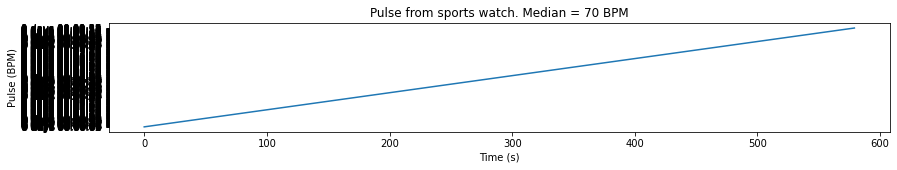

In [9]:
fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_polar.iloc[:,0]);

plt.ylabel('Pulse (BPM)')
plt.xlabel('Time (s)');
plt.title('Pulse from sports watch. Median = %i BPM' % pulse)

fig.savefig('%s_pulse.pdf' % date, bbox_inches='tight', facecolor='white')

### Temperature

Here we calculate the mean value of the temperature:

In [9]:
temperature = data_polar.iloc[:,2].median()
temperature

24.6

Then we look at the temperature:

AttributeError: 'RangeIndex' object has no attribute 'total_seconds'

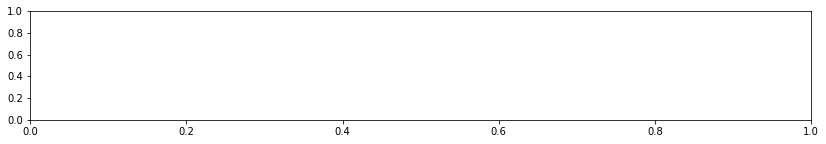

In [10]:
fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_polar.index.total_seconds(), data_polar.iloc[:,1]);

plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Time (s)');
plt.title('Temperature from sports watch. Median = %i $^\circ$C' % temperature)

fig.savefig('%s_temperature.pdf' % date, bbox_inches='tight', facecolor='white')

## Read and check Data

Reading CSV files from [Physics Toolbox Sensor Suite](https://play.google.com/store/apps/dev?id=6483394247866966083&hl=en) by [Vieyra Software](https://www.vieyrasoftware.net/).

In [11]:
data_phone = pd.read_csv(fn_IMU, index_col=0, low_memory=False)

### Check files

Before moving on we should briefly check what we have imported.

In [12]:
data_phone

gFx     gFy     gFz      ax      ay      az      wx      wy  \
time                                                                         
18.858546  -0.9822 -0.0277  0.1847  0.0016  0.0058  0.0200 -0.0031 -0.0232   
18.925803  -0.9823 -0.0326  0.1884  0.0358  0.0043  0.0183  0.0037  0.0101   
18.995144  -0.9649 -0.0316  0.1967  0.0324 -0.0838  0.1823  0.0423 -0.0391   
19.058998  -0.9564 -0.0210  0.1780  0.1224  0.0461  0.1790  0.0980  0.0545   
19.125745  -0.9862 -0.0270  0.1862  0.0921  0.0438  0.0585  0.0728  0.1017   
...            ...     ...     ...     ...     ...     ...     ...     ...   
597.916267 -0.9834 -0.0372  0.1826  0.0299  0.0501  0.1057 -0.0185  0.0527   
597.985072 -0.9844 -0.0402  0.1756  0.0093 -0.0062  0.0739 -0.0087  0.0860   
598.049607 -0.9863 -0.0259  0.1780 -0.0098 -0.0475  0.0243  0.0029  0.0195   
598.120286 -0.9968 -0.0394  0.1703  0.0114  0.0811  0.0498 -0.0073  0.0702   
598.184350 -0.9856 -0.0286  0.1637 -0.0474 -0.0183 -0.0155 -0.0012  0.0421   

                wz          p       Bx      By       Bz     I   Azimuth  \
time                                                                      
18.858546  -0.0002  1014.8853  51.1125 -8.2125 -31.0500  46.0  114.1153   
18.925803   0.0057  1014.8906  51.1500 -8.1188 -31.1813  46.0  114.1326   
18.995144   0.0237  1014.8958  51.2063 -8.0625 -31.1063  46.0  114.2935   
19.058998   0.0599  1014.8926  51.2438 -8.1000 -30.9938  46.0  114.8761   
19.125745   0.0192  1014.8909  51.1688 -8.1188 -30.9938  46.0  115.2064   
...            ...        ...      ...     ...      ...   ...       ...   
597.916267  0.0047  1014.9001  50.0250 -9.0188 -31.4625  53.0  114.6529   
597.985072  0.0066  1014.8997  50.1000 -9.0375 -31.4250  53.0  114.6057   
598.049607 -0.0000  1014.8894  50.0813 -9.0750 -31.2000  53.0  114.6057   
598.120286 -0.0069  1014.8926  50.2688 -9.0563 -31.0313  53.0  114.7702   
598.184350 -0.0108  1014.8840  50.1375 -9.0938 -30.9375  53.0  114.6770   

             Pitch     Roll     Gain  Latitude  Longitude  
time                                                       
18.858546   1.8953 -79.7397  42.9659  59.93195  10.719273  
18.925803   1.8672 -79.7635  42.9659  59.93195  10.719273  
18.995144   1.7468 -79.5914  42.9659  59.93195  10.719273  
19.058998   1.5153 -79.6555  42.9659  59.93195  10.719273  
19.125745   1.3612 -79.8934  48.6464  59.93195  10.719273  
...            ...      ...      ...       ...        ...  
597.916267  2.0933 -79.3810  46.5603  59.93181  10.718846  
597.985072  2.0711 -79.6543  46.5603  59.93181  10.718846  
598.049607  2.0711 -79.6543  43.5004  59.93181  10.718846  
598.120286  2.1020 -79.8943  43.5004  59.93181  10.718846  
598.184350  2.0866 -80.1106  43.5004  59.93181  10.718846  

[8673 rows x 20 columns]

This is a description of the variables:

| Name           | Description   | Unit |
|:----           |:-----------   |:---- |
| gFx            | g-force X     | FN/Fg |
| gFy            | g-force Y     | FN/Fg |
| gFz            | g-force Z     | FN/Fg |
| ax             | linear acceleration X | m/s2 |
| ay             | linear acceleration Y | m/s2 |
| az             | linear acceleration Z | m/s2 |
| wx             | gyroscope X   | rad/s |
| wy             | gyroscope Y   | rad/s |
| wz             | gyroscope Z   | rad/s |
| p              | barometer     | Pa |
| Bx             | magnetometer X | μT |
| By             | magnetometer Y | μT |
| Bz             | magnetometer Z | μT |
| I              | light meter   | lx |
| Azimuth        | inclinometer  | |
| Pitch          | inclinometer  | |
| Roll           | inclinometer  | |
| Gain           | sound meter   | dB |
| Latitude       | GPS Latitude  | degrees |
| Longitude      | GPS Longitude | degrees |
| Speed | m/s)   | GPS Speed     | km/h |

In [13]:
# The sampling rate is the total number of samples divided by time
sr = len(data_phone)/data_phone.index[-1]
sr

14.498874803394639

In [14]:
data_phone.index[0]

18.858546

In [15]:
start_time = data_phone.index[0]
data_phone['Time'] = (data_phone.index - start_time).dt.total_seconds()


AttributeError: 'Float64Index' object has no attribute 'dt'

In [16]:
# Cutting off the part before the clap
data_without_beginning = data_phone.tail(-30*int(sr))

In [17]:
# Cutting off the last 20 seconds of the file
data_phone = data_without_beginning.head(-20*int(sr))

In [18]:
data_phone

gFx     gFy     gFz      ax      ay      az      wx      wy  \
time                                                                         
46.915623  -0.9936 -0.0248  0.0803  0.0105  0.0311 -0.0095 -0.0041  0.0110   
46.982115  -0.9984 -0.0313  0.0907 -0.0100  0.0011  0.0065 -0.0041  0.0110   
47.050574  -0.9972 -0.0306  0.0921 -0.0100  0.0527  0.0462 -0.0024 -0.0089   
47.115832  -0.9944 -0.0336  0.0866 -0.0064 -0.0390 -0.0241  0.0009  0.0127   
47.182526  -0.9950 -0.0313  0.0899  0.0167  0.0018 -0.0107  0.0021 -0.0098   
...            ...     ...     ...     ...     ...     ...     ...     ...   
579.210090 -0.9946 -0.0437  0.0951 -0.0117 -0.0681 -0.0198 -0.0035 -0.0052   
579.279669 -0.9953 -0.0469  0.1056 -0.0073  0.0236  0.0063 -0.0041 -0.0147   
579.343947 -0.9933 -0.0330  0.1044  0.0065  0.0399  0.0275 -0.0050 -0.0047   
579.410505 -0.9908 -0.0469  0.0988  0.0075 -0.0623  0.0055 -0.0020 -0.0021   
579.479622 -0.9911 -0.0393  0.1004  0.0144  0.0043  0.0037  0.0050 -0.0037   

                wz          p       Bx      By       Bz     I   Azimuth  \
time                                                                      
46.915623  -0.0082  1014.9001  53.5313 -8.3250 -27.0375  49.0  113.8615   
46.982115  -0.0082  1014.9021  53.5313 -8.4000 -27.0938  49.0  113.8013   
47.050574  -0.0008  1014.8955  53.5125 -8.3625 -27.0188  49.0  113.8013   
47.115832   0.0009  1014.8918  53.5313 -8.4188 -27.0938  49.0  113.7500   
47.182526   0.0002  1014.8943  53.4750 -8.4375 -27.1875  49.0  113.8000   
...            ...        ...      ...     ...      ...   ...       ...   
579.210090 -0.0034  1014.8977  53.0813 -8.1938 -28.1813  55.0  114.3061   
579.279669 -0.0024  1014.9050  53.0625 -8.1000 -28.1438  55.0  114.3814   
579.343947  0.0021  1014.8972  52.9875 -8.1000 -28.0688  55.0  114.3269   
579.410505  0.0032  1014.8857  52.9688 -8.1375 -28.0688  55.0  114.2773   
579.479622  0.0020  1014.8938  52.9875 -8.3063 -28.0688  55.0  114.3966   

             Pitch     Roll     Gain  Latitude  Longitude  
time                                                       
46.915623   1.7560 -84.7846  41.3107  59.93195  10.719273  
46.982115   1.7666 -84.8332  41.3107  59.93195  10.719273  
47.050574   1.7666 -84.8332  41.0691  59.93195  10.719273  
47.115832   1.7265 -84.8109  41.0691  59.93195  10.719273  
47.182526   1.7539 -84.7915  41.0691  59.93195  10.719273  
...            ...      ...      ...       ...        ...  
579.210090  2.3054 -84.4197  42.1917  59.93181  10.718846  
579.279669  2.3658 -84.3794  42.1917  59.93181  10.718846  
579.343947  2.3422 -84.3581  42.1917  59.93181  10.718846  
579.410505  2.3019 -84.3299  41.4423  59.93181  10.718846  
579.479622  2.3380 -84.3108  41.4423  59.93181  10.718846  

[7973 rows x 20 columns]

## Sound and light levels

In [19]:
light_level = data_phone.I.median()
light_level

54.0

<Figure size 1008x144 with 0 Axes>

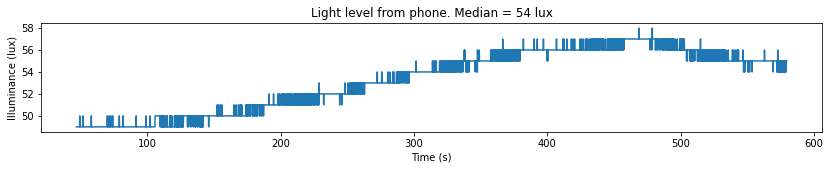

In [20]:
fig = plt.figure(figsize=(14,2))

fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_phone.index, data_phone.I);

plt.ylabel('Illuminance (lux)')
plt.xlabel('Time (s)');
plt.title('Light level from phone. Median = %i lux' % light_level)

fig.savefig('%s_illuminance.pdf' % date, bbox_inches='tight', facecolor='white')

In [21]:
sound_level = data_phone.Gain.median()
sound_level

41.5951

<Figure size 1008x144 with 0 Axes>

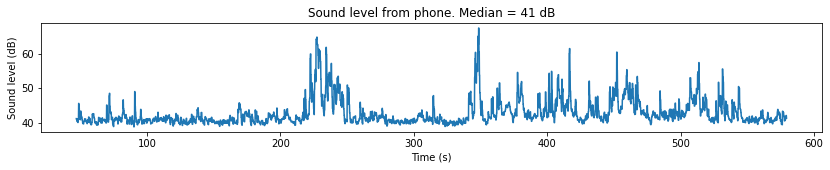

In [22]:
fig = plt.figure(figsize=(14,2))

fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_phone.index, data_phone.Gain);

plt.ylabel('Sound level (dB)')
plt.xlabel('Time (s)');
plt.title('Sound level from phone. Median = %i dB' % sound_level)

fig.savefig('%s_sound_level.pdf' % date, bbox_inches='tight', facecolor='white')

In [23]:
barometer = data_phone.p.median()
barometer

1014.8816

<Figure size 1008x144 with 0 Axes>

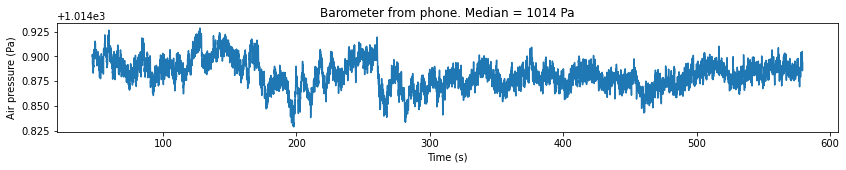

In [24]:
fig = plt.figure(figsize=(14,2))

fig, ax = plt.subplots(figsize=(14,2))
plt.plot(data_phone.index, data_phone.p);

plt.ylabel('Air pressure (Pa)')
plt.xlabel('Time (s)');
plt.title('Barometer from phone. Median = %i Pa' % barometer)

fig.savefig('%s_barometer.pdf' % date, bbox_inches='tight', facecolor='white')

## Descriptive statistics

Then we can look at some basic descriptive statistics.

In [25]:
data_stats = data_phone.describe(include='all')
data_stats

gFx          gFy          gFz           ax           ay  \
count  7973.000000  7973.000000  7973.000000  7973.000000  7973.000000   
mean     -0.994017    -0.036825     0.094814    -0.000058    -0.000650   
std       0.004310     0.006836     0.007506     0.016997     0.030977   
min      -1.013900    -0.063600     0.053200    -0.067400    -0.119800   
25%      -0.996100    -0.041000     0.090600    -0.009800    -0.014800   
50%      -0.994100    -0.037100     0.095100    -0.000600    -0.001500   
75%      -0.992000    -0.032500     0.099400     0.009300     0.013600   
max      -0.970800    -0.010900     0.124600     0.077300     0.103500   

                az           wx           wy           wz            p  \
count  7973.000000  7973.000000  7973.000000  7973.000000  7973.000000   
mean     -0.000974    -0.000125    -0.000245     0.000104  1014.881798   
std       0.031077     0.008674     0.012624     0.004591     0.014162   
min      -0.118500    -0.031300    -0.042100    -0.017700  1014.829300   
25%      -0.020200    -0.004000    -0.009500    -0.002700  1014.872800   
50%      -0.000900    -0.000500    -0.000500     0.000300  1014.881600   
75%       0.020500     0.003100     0.008700     0.002900  1014.890600   
max       0.092300     0.038000     0.042600     0.019500  1014.928500   

                Bx           By           Bz            I      Azimuth  \
count  7973.000000  7973.000000  7973.000000  7973.000000  7973.000000   
mean     53.214435    -7.958727   -27.771912    53.312304   113.642185   
std       0.342081     0.228758     0.438452     2.729583     0.488719   
min      52.237500    -8.756300   -29.587500    49.000000   112.660500   
25%      52.968800    -8.100000   -28.068800    51.000000   113.272100   
50%      53.193800    -7.950000   -27.806300    54.000000   113.527500   
75%      53.418800    -7.800000   -27.487500    56.000000   113.918500   
max      54.900000    -7.012500   -26.381300    58.000000   114.866800   

             Pitch         Roll         Gain     Latitude    Longitude  
count  7973.000000  7973.000000  7973.000000  7973.000000  7973.000000  
mean      2.109431   -84.543139    42.937835    59.931853    10.718909  
std       0.239614     0.230482     3.822470     0.000077     0.000278  
min       1.335600   -85.296000    38.935700    59.931654    10.717963  
25%       1.952800   -84.685100    40.653700    59.931821    10.718857  
50%       2.133400   -84.521600    41.595100    59.931824    10.718891  
75%       2.294000   -84.398100    43.653000    59.931888    10.718904  
max       2.657600   -83.728600    67.317100    59.932124    10.719861

The histograms can tell us something about the distribution of the linear acceleration data. 

## Investigating the linear acceleration

To simplify the plotting, we center the data around the mean value of each column.

In [26]:
data_centered = data_phone.sub(data_phone.mean())

We apply a Savitzky-Golay filter on the whole dataframe: 

In [27]:
order = 4 # The polynomial order of the filter
window_s = 10 # The window size in seconds

# The window size needs to be an odd number, so we need to check for that
if (window_s % 2) == 0:
   window = int(window_s*sr)+1
else:
   window = int(window_s*sr)

data_sg = pd.DataFrame(savgol_filter(data_centered, window, order, axis=0),
                                columns=data_centered.columns,
                                index=data_centered.index)

In [28]:
# Smoothing the signal with a running average filter
#window1 = int(sr*5) 
#data_sg = data_phone.rolling(window1,center=True,win_type='boxcar',min_periods=1).mean()

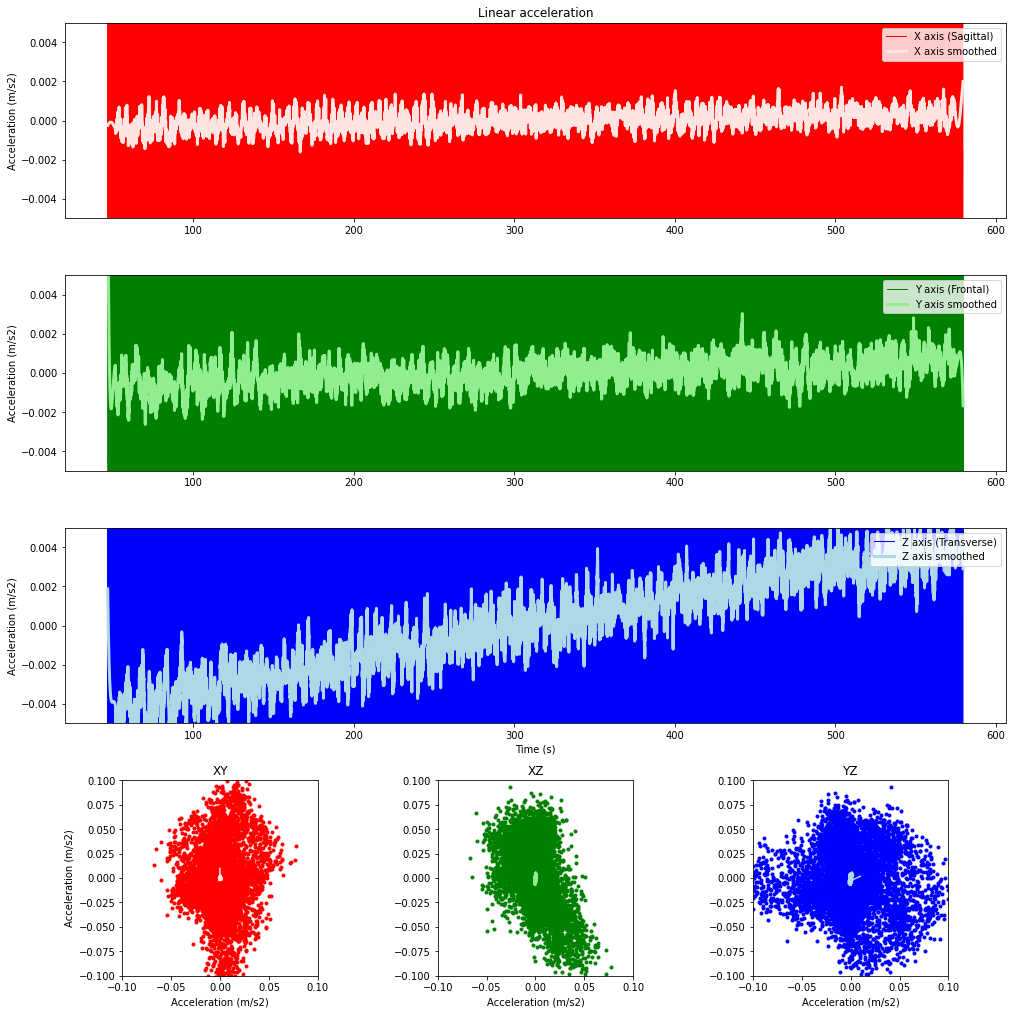

In [29]:
fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3)
ax1.plot(data_centered['ax'], lw=1, label='X axis (Sagittal)', color='red')
ax1.plot(data_sg['ax'], lw=3, label='X axis smoothed', color='mistyrose')
ax1.legend(loc='upper right')
ax1.set_ylim(-0.005, 0.005)
plt.ylabel('Acceleration (m/s2)');
plt.title('Linear acceleration')

ax2 = plt.subplot2grid((4, 3), (1, 0), colspan=3, sharex=ax1, sharey=ax1)
ax2.plot(data_centered['ay'], lw=1, label='Y axis (Frontal)', color='green')
ax2.plot(data_sg['ay'], lw=3, label='Y axis smoothed', color='lightgreen')
ax2.legend(loc='upper right')
#ax2.set_ylim(-0.15, 0.15)
plt.ylabel('Acceleration (m/s2)');

ax3 = plt.subplot2grid((4, 3), (2, 0), colspan=3, sharex=ax1, sharey=ax1)
ax3.plot(data_centered['az'], lw=1, label='Z axis (Transverse)', color='blue')
ax3.plot(data_sg['az'], lw=3, label='Z axis smoothed', color='lightblue')
ax3.legend(loc='upper right')
#ax3.set_ylim(-0.15, 0.15)
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Time (s)');

ax4 = plt.subplot2grid((4, 3), (3, 0))
plt.plot(data_centered['ax'], data_centered['ay'], color='red', marker='.', linestyle='') #XY plane
plt.plot(data_sg['ax'], data_sg['ay'], color='mistyrose') #XY plane
plt.ylabel('Acceleration (m/s2)');
plt.xlabel('Acceleration (m/s2)');
plt.title('XY')
ax4.set_xlim(-0.1, 0.1)
ax4.set_ylim(-0.1, 0.1)
ax4.set_aspect('equal')

ax5 = plt.subplot2grid((4, 3), (3, 1), sharex=ax4, sharey=ax4)
plt.plot(data_centered['ax'], data_centered['az'], color='green', marker='.', linestyle='') #XZ plane
plt.plot(data_sg['ax'], data_sg['az'], color='lightgreen') #XZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('XZ')
#ax5.set_xlim(-0.15, 0.15)
#ax5.set_ylim(-0.15, 0.15)
ax5.set_aspect('equal')

ax6 = plt.subplot2grid((4, 3), (3, 2), sharex=ax4, sharey=ax4)
plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.xlabel('Acceleration (m/s2)');
plt.title('YZ')
#ax6.set_xlim(-0.15, 0.15)
#ax6.set_ylim(-0.15, 0.15)
ax6.set_aspect('equal')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("%s_linear_acceleration.pdf" % date, bbox_inches='tight', facecolor='white')

Making a plot of the transverse (horizontal) plane without axes. This can be nice to use for visualization.

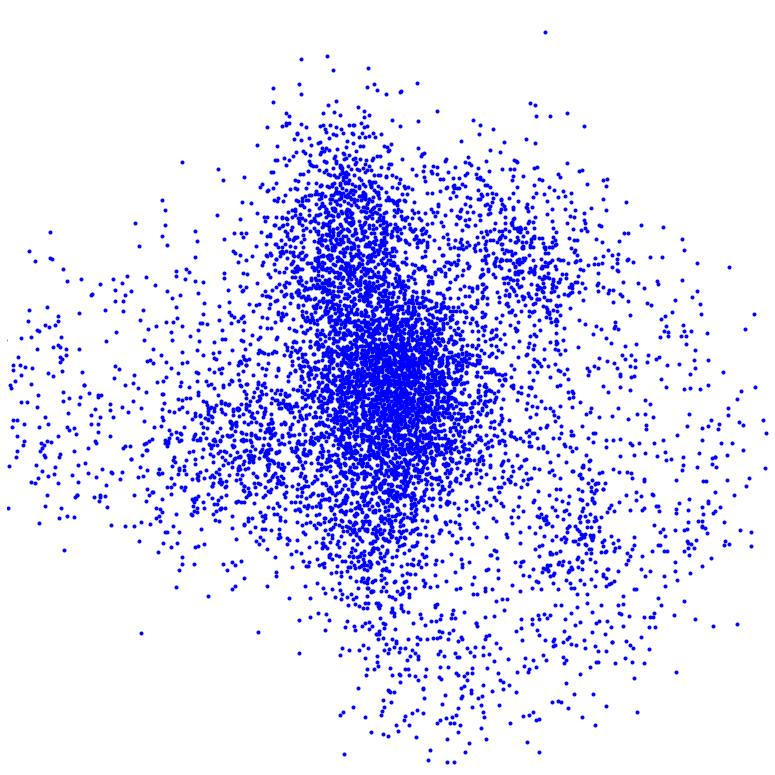

In [30]:
fig, ax = plt.subplots(figsize=(14,14))

plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
#plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.box(False)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_aspect('equal')
plt.savefig("%s_transverse_acceleration.pdf" % date, bbox_inches='tight')

Calculating the spatial range as the area covered by the standard deviation of the data. This accounts for the center "blob" of the activity.

In [31]:
spatial_range = data_centered['ay'].std()*data_centered['az'].std()*1000
spatial_range

0.9626807779180631

I am unsure of the unit here. I guess it is in m/s2, but does that actually make any sense?

## Quantity of Motion

We will estimate the "quantity of motion" by looking at how much the acceleration values change over time. 

In [32]:
# Calculate difference between samples
displacement = (np.roll(data_centered, -1, axis=0) - data_centered)

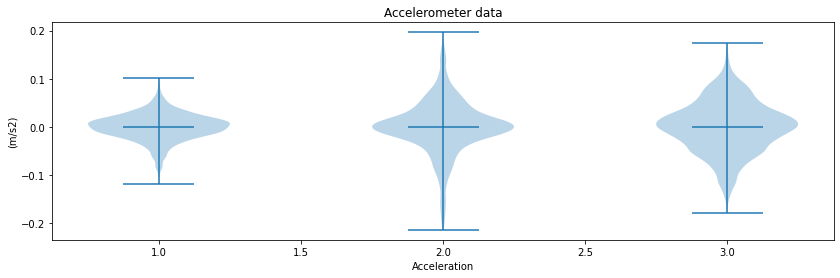

In [33]:
fig = plt.figure(figsize=(14,4))

plt.violinplot([displacement.ax, displacement.ay, displacement.az], showmeans=True)
plt.title('Accelerometer data')
#nocolumns = list(range(1,len(vels_group[46].columns)+1))
#ax.set_xticks(nocolumns)
#plt.xticklabels(["", "X", "", "Y", "", "Z"])
plt.xlabel('Acceleration');
plt.ylabel('(m/s2)');
fig.savefig("%s_acceleration_violinplots.pdf" % date, bbox_inches='tight',facecolor='white')

## Cumulative distance travelled

In [34]:
# Calculate the vector norm of the displacement
dispnorm = np.sqrt(
         displacement.ax ** 2 +
         displacement.ay ** 2 +
         displacement.az ** 2
    )

In [35]:
dispnorm.mean()

0.07067707341960158

In [36]:
dispnorm.median()

0.06319984177195383

In [37]:
dispnorm.std()

0.04182746725281941

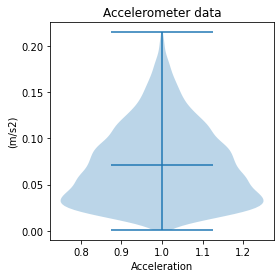

In [38]:
fig = plt.figure(figsize=(4,4))

plt.violinplot(dispnorm, showmeans=True)
plt.title('Accelerometer data')
#nocolumns = list(range(1,len(vels_group[46].columns)+1))
#ax.set_xticks(nocolumns)
#plt.xticklabels(["", "X", "", "Y", "", "Z"])
plt.xlabel('Acceleration');
plt.ylabel('(m/s2)');
fig.savefig("%s_acceleration_norm.pdf" % date, bbox_inches='tight',facecolor='white')

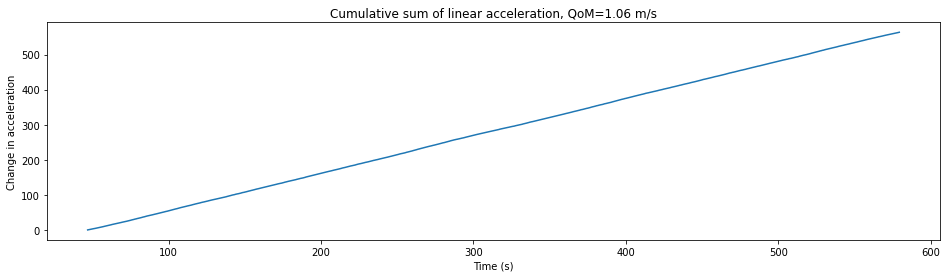

In [39]:
dispnormsum = dispnorm.cumsum() # Calculating the cumulative sum of all avalues
time_array = dispnormsum.index[1:]
duration = time_array[-1]-time_array[1]
qom = dispnormsum.iloc[-1]/duration # Finding the last value as Quantity of Motion

fig = plt.figure(figsize=(16,6))
ax = plt.subplot(1, 1, 1)
ax = dispnormsum.plot(figsize=(16,4)) #Indicate group number to plot
#ax.set_xlim(100, 110)
#ax.set_ylim(80, 110)
plt.xlabel('Time (s)');
plt.ylabel('Change in acceleration');
#plt.legend(loc='upper left')
plt.title('Cumulative sum of linear acceleration, QoM=%.2f m/s' %qom)
fig.savefig("%s_cumsum.pdf" % date, bbox_inches='tight',facecolor='white')

## Combined acceleration plot

In [40]:
window2

NameError: name 'window2' is not defined

In [41]:
order = 2 # The polynomial order of the filter
# The window size in seconds
window_s1 = 5
window_s2 = 60 

# The window size needs to be an odd number, so we need to check for that
if (window_s1 % 2) == 0:
   window1 = int(window_s1*sr)
else:
   window1 = int(window_s1*sr)+1

if (window_s % 2) == 0:
   window2 = int(window_s2*sr)
else:
   window2 = int(window_s2*sr)+1

dispnorm_sg1 = savgol_filter(dispnorm, window1, order)
dispnorm_sg2 = savgol_filter(dispnorm, window2, order)

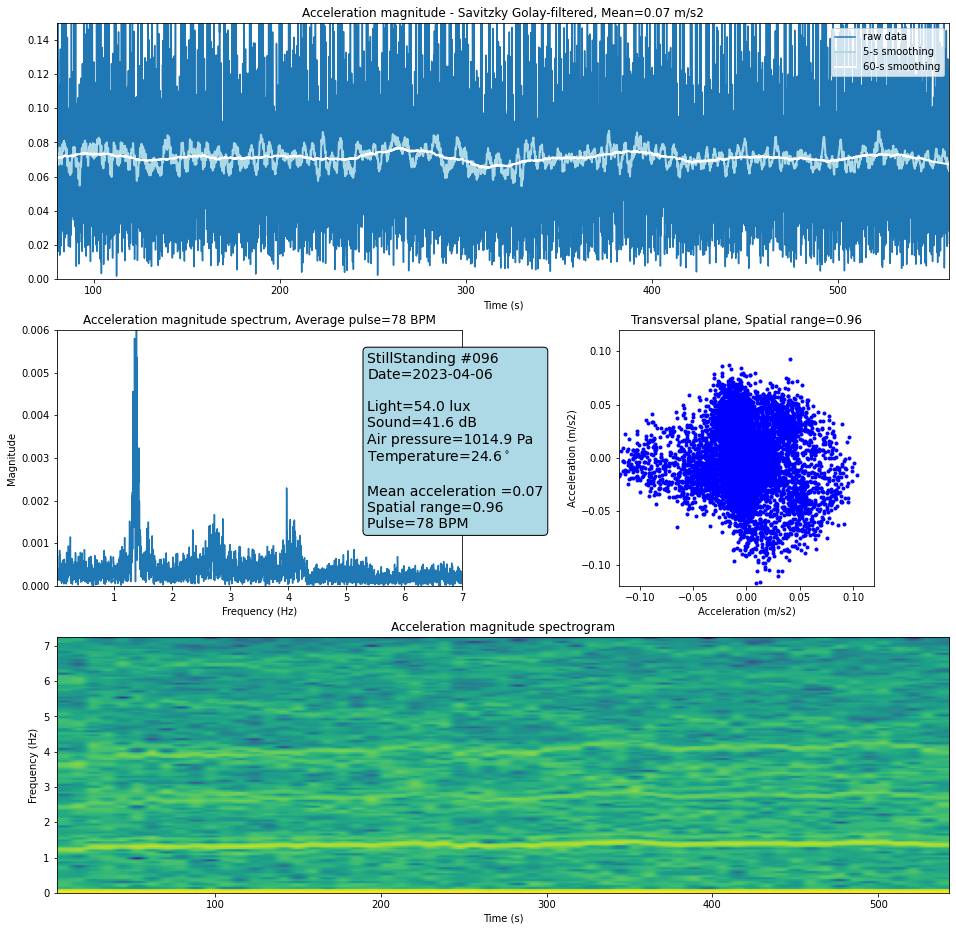

In [42]:
fig = plt.figure(figsize=(16,16))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)

ax1.plot(dispnorm, label='raw data')
ax1.plot(dispnorm.index, dispnorm_sg1, lw=2, label='5-s smoothing', color='lightblue')
ax1.plot(dispnorm.index, dispnorm_sg2, lw=2, label='60-s smoothing', color='white')
ax1.set_xlim(80, 560)
ax1.set_ylim(0, 0.15)
ax1.legend(loc='upper right')
plt.xlabel('Time (s)');
plt.title('Acceleration magnitude - Savitzky Golay-filtered, Mean=%.2f m/s2' % dispnorm.mean())

ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
powerSpectrum, freqenciesFound, imageAxis = plt.magnitude_spectrum(dispnorm, Fs=sr)
ax2.set_xlim(0.001, 7)
ax2.set_ylim(0,0.006)
plt.title('Acceleration magnitude spectrum, Average pulse=%i BPM' %pulse)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

ax3 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
plt.plot(data_centered['ay'], data_centered['az'], color='blue', marker='.', linestyle='') #ZY plane
#plt.plot(data_sg['ay'], data_sg['az'], color='lightblue') #YZ plane
plt.xlabel('Acceleration (m/s2)');
plt.ylabel('Acceleration (m/s2)');
plt.title('Transversal plane, Spatial range=%.2f' %spatial_range)
ax3.set_xlim(-0.12, 0.12)
ax3.set_ylim(-0.12, 0.12)
ax3.set_aspect('equal')

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='lightblue', alpha=1)
textstr = '\n'.join((
    r'StillStanding #%s' % (stillstanding_no, ),
    r'Date=%s' % (date, ),
    r' ',
#    r'Environment:',
    r'Light=%.1f lux' % (light_level, ),
    r'Sound=%.1f dB' % (sound_level, ),
    r'Air pressure=%.1f Pa' % (barometer, ),
    r'Temperature=%.1f$^\circ$' % (temperature, ),
    r' ',
    r'Mean acceleration =%.2f' % (dispnorm.mean(), ),
    r'Spatial range=%.2f' % (spatial_range, ),
    r'Pulse=%i BPM' % (pulse, )    
))

ax3.text(0.25, 2.5, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(dispnorm, Fs=sr)
#ax4.set_ylim(0.001, 3)
plt.title('Acceleration magnitude spectrogram')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

fig.savefig("%s_combined_plot.pdf" % date, bbox_inches='tight',facecolor='white')

## Spherical video

We start by merging the two LRV files into one

In [43]:
video = mg.MgVideo(video_fn, skip=5)

Skipping frames: |████████████████████████████████████████| 100.0% Complete


Rendering horizontal videogram: |██████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████| 100.0% Complete


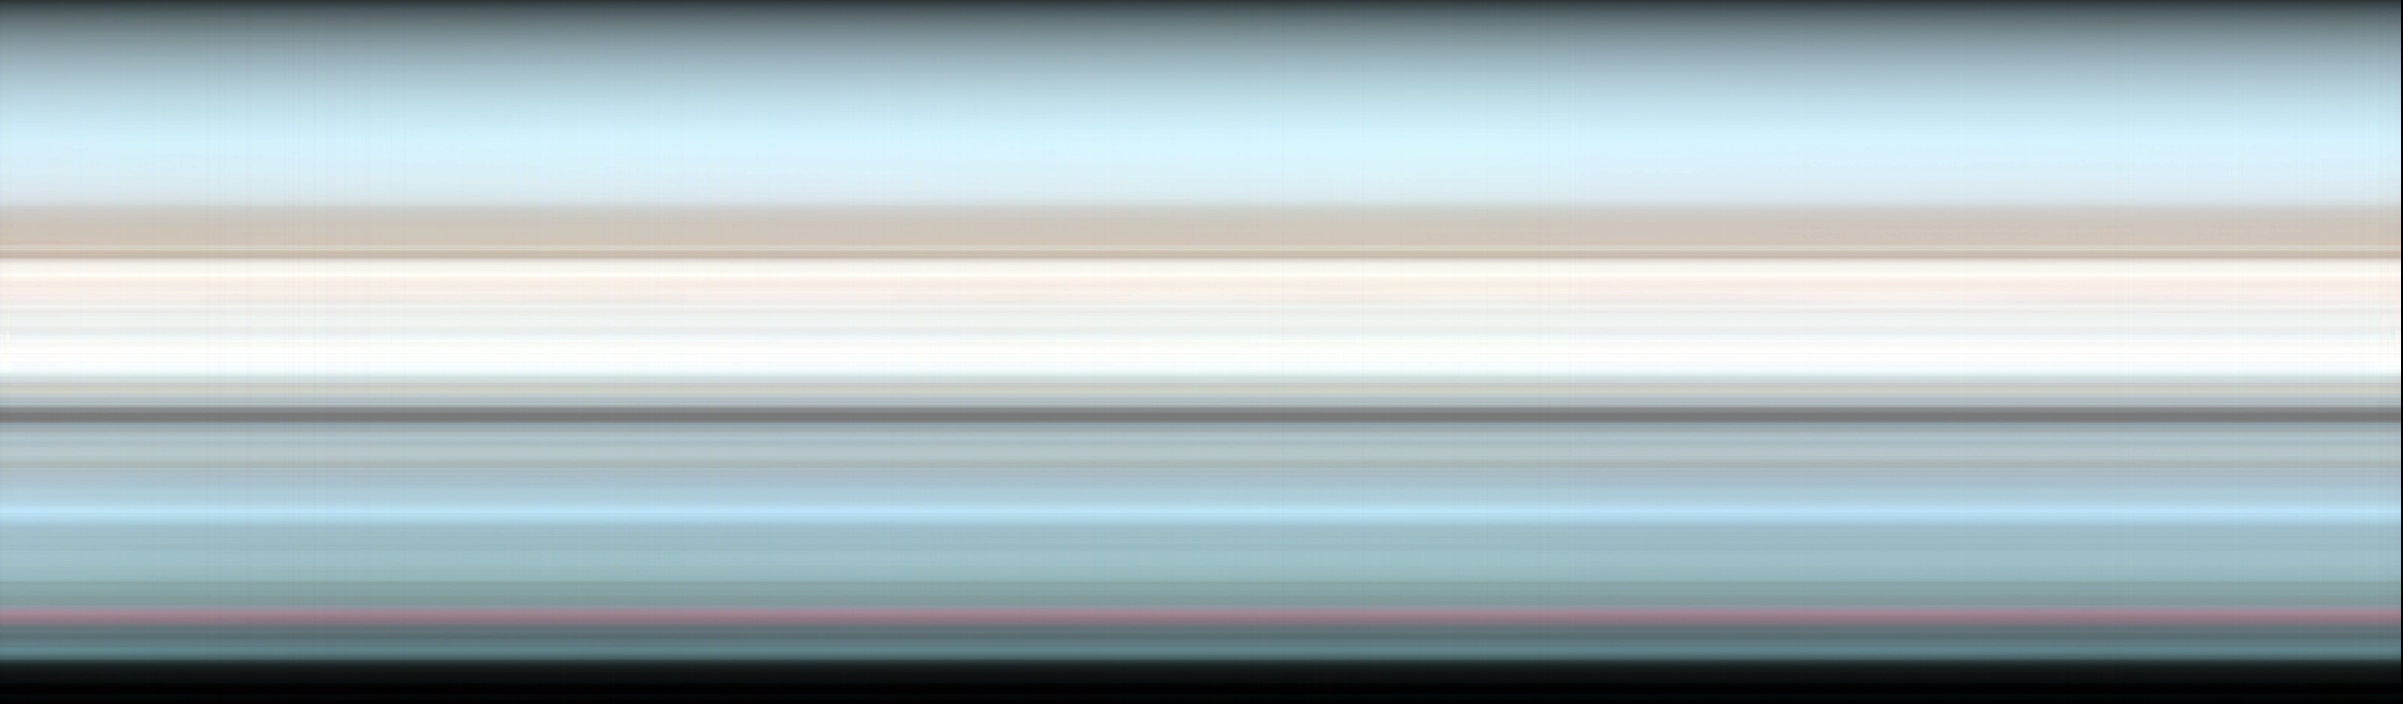

MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_spherical_trim_skip_vgy.png')

In [44]:
videograms = video.videograms()
videograms[1].show(mode="notebook")

Rendering average image: |█████████████████████████████████████| 100.0% Complete


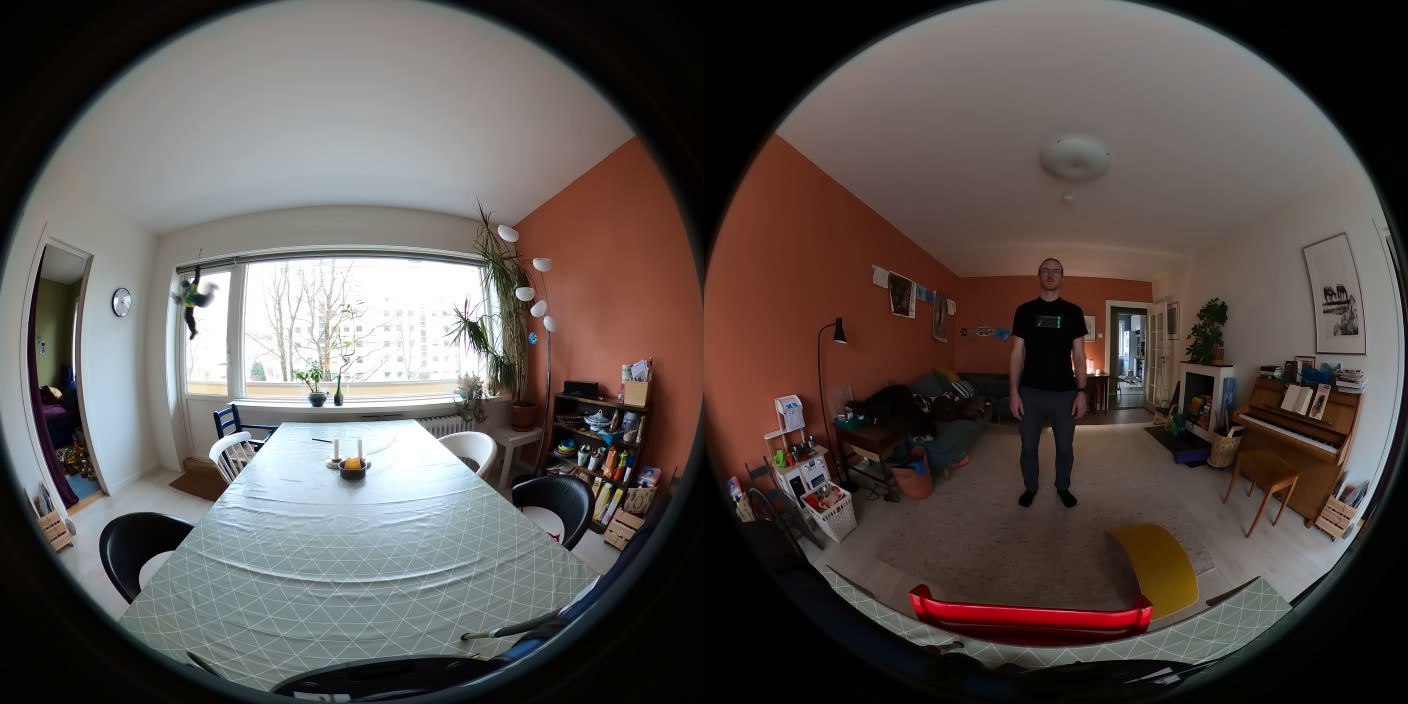

MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_spherical_trim_skip_average.png')

In [45]:
video.average().show(mode="notebook")

### MG audio

Rendering spectrogram SSM: |███████████████████████████████████| 100.0% Complete


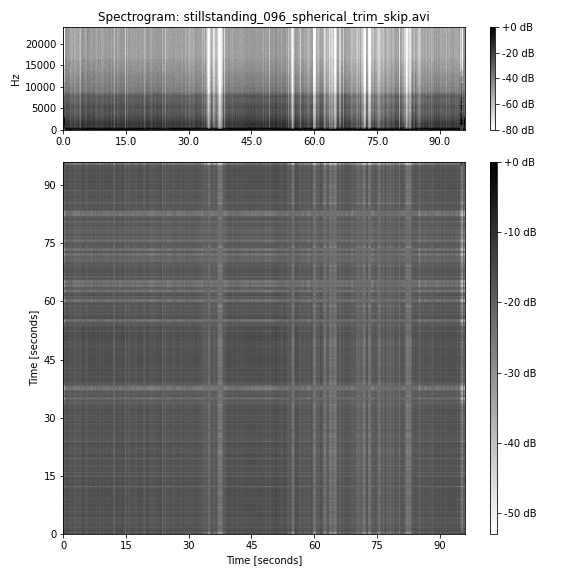

MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_spherical_trim_skip_ssm.png')

In [46]:
spectrossm = video.ssm(features='spectrogram')
spectrossm.show(mode="notebook") # view both SSMs

In [51]:
video = mg.MgVideo(video_fn)

MgFigure(figure_type='audio.waveform')

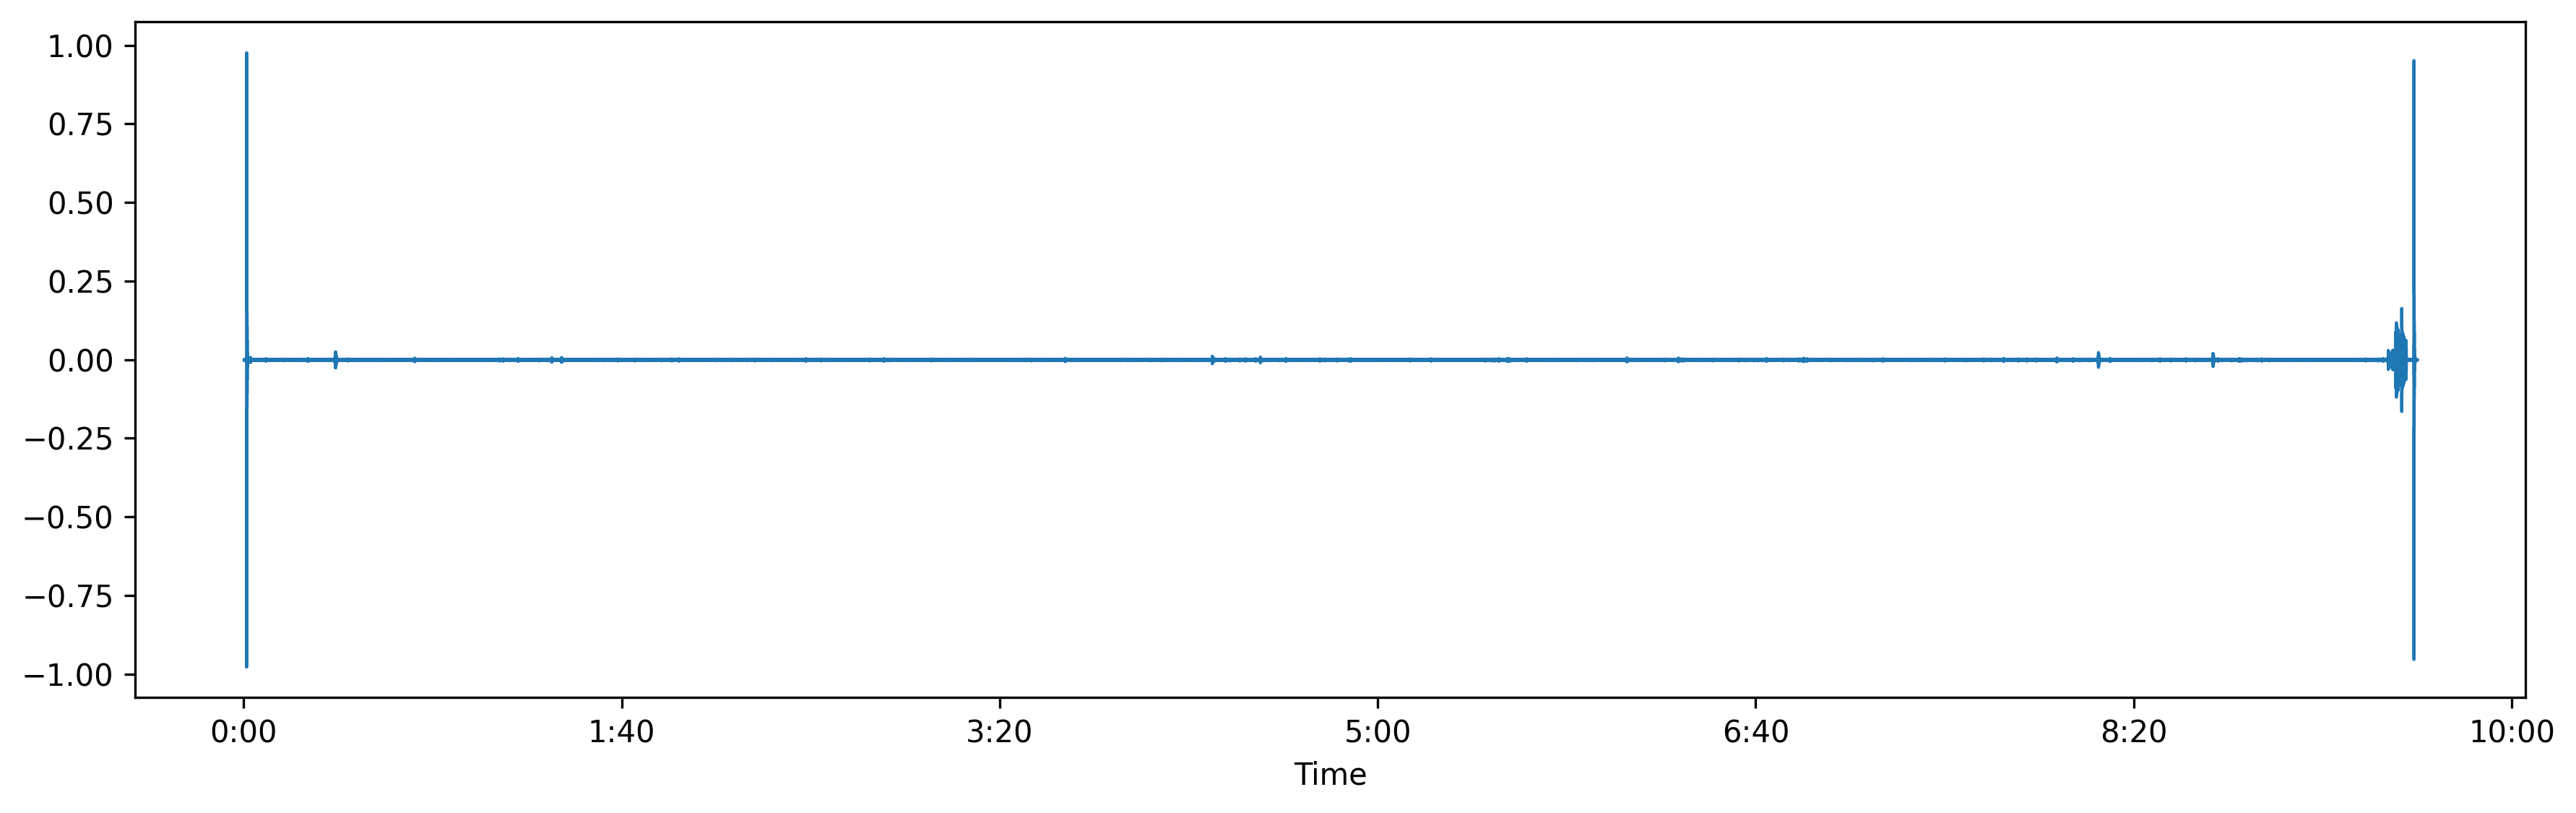

In [52]:
video.audio.waveform(title='')

In [ ]:
video.audio.spectrogram(title='')

In [ ]:
#video.audio.descriptors(title='')

## Video analysis

We start by investigating the 360 files. The recording is split across two files and each of these have two video layers internally.

In [48]:
video_fn = '../2-processed/stillstanding_096_arj_trim_crop.mp4'
video = mg.MgVideo(video_fn, skip=5)

Skipping frames: |████████████████████████████████████████| 100.0% Complete


In [49]:
video.videograms()

Rendering horizontal videogram: |██████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████| 100.0% Complete


MgList('[MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_arj_trim_crop_skip_vgx.png'), MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_arj_trim_crop_skip_vgy.png')]')

In [50]:
video.average()

Rendering average image: |█████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_arj_trim_crop_skip_average.png')

In [51]:
video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Downloads/Still Standing/04/2023-04-06/2-processed/stillstanding_096_arj_trim_crop_skip_motion_average.png')

In [103]:
video_fn = '../2-processed/2023-02-26_057_room_trim_crop.mp4'
video = mg.MgVideo(video_fn, skip=5)

Skipping frames: |████████████████████████████████████████| 100.0% Complete
Converting to mp4: |████████████████████████████████████████| 100.0% Complete


In [104]:
video.videograms()

Rendering horizontal videogram: |████████████████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████████████| 100.0% Complete


MgList('[MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-26/2-processed/2023-02-26_057_room_trim_crop_skip_vgx.png'), MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-26/2-processed/2023-02-26_057_room_trim_crop_skip_vgy.png')]')

In [ ]:
video.average()

Converting to avi: |██████████████████████------------------| 56.4% Complete

In [ ]:
video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

### Average subtraction

In [6]:
video = mg.MgVideo('spherical_trim_skip.avi')
# returns an MgVideo with background subtracted on the average of all video frames
subtraction = video.subtract()

Converting to mp4: |████████████████████████████████████████| 100.0% Complete
spherical_trim_skip.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete
Subtracting background: |██████████████████████████████████████| 100.0% Complete
Converting to mp4: |████████████████████████████████████████| 100.0% Complete


In [7]:
subtraction.videograms()

Rendering horizontal videogram: |██████████████████████████████| 100.0% Complete
Rendering vertical videogram: |████████████████████████████████| 100.0% Complete


MgList('[MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_vgx.png'), MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_vgy.png')]')

In [8]:
subtraction.average()

Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_subtracted_0_average.png')

### Motion video

In [61]:
video = mg.MgVideo('../2-processed/stillstanding_070_arj_trim_crop.mp4')

In [62]:
motion = video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

Rendering motion-video, -grams, -plots, -data: |████████████████████████████████████████| 100.0% Complete
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


In [63]:
video = mg.MgVideo('../2-processed/stillstanding_070_room_trim_crop.mp4')

In [ ]:
motion = video.motion(inverted_motionvideo=True, inverted_motiongram=True).average()

Rendering motion-video, -grams, -plots, -data: |█████████████████████████---------------| 63.3% Complete

In [28]:
video = mg.MgVideo('spherical_trim_skip.mp4')
motion = video.motion(thresh=0.5).average()

Converting to mp4: |████████████████████████████████████████| 100.0% Complete
Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim_skip_motion_0.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |█████████████████████████████████████| 100.0% Complete


In [65]:
video = mg.MgVideo('spherical_trim.mp4')
motion = video.motion(inverted_motionvideo=False, inverted_motiongram=False, equalize_motiongram=False, thresh=0.).average()

spherical_trim.mp4 is already in mp4 container.
Rendering motion-video, -grams, -plots, -data: |███████████████| 100.0% Complete
/home/alexander/Dropbox (UiO)/Aktiv/Still Standing/02/2023-02-11/2-cooked/spherical_trim_motion.mp4 is already in mp4 container.
Converting to avi: |████████████████████████████████████████| 100.0% Complete
Rendering average image: |████████████████████████████████████████| 100.0% Complete


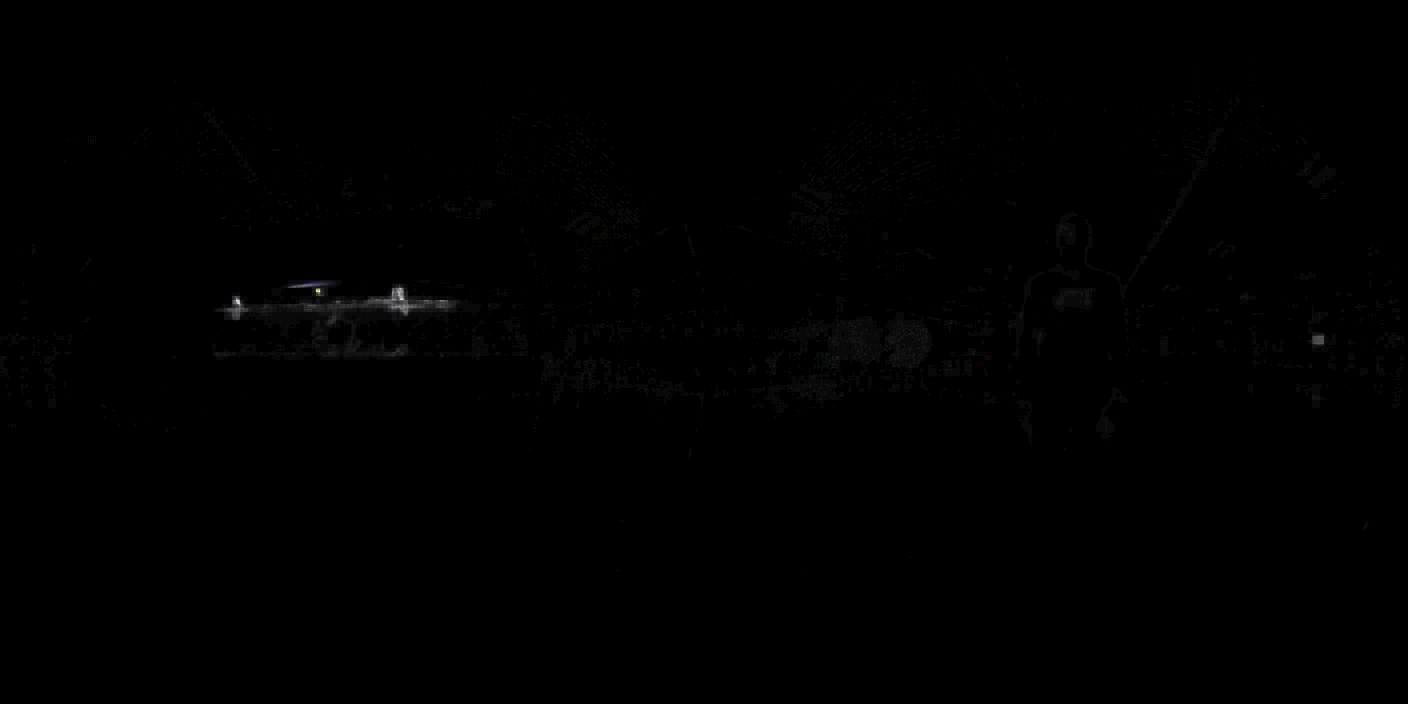

MgImage('/home/alexander/Downloads/Still Standing/02/2023-02-05/2-cooked/spherical_trim2_motion_average.png')

In [12]:
motion.show(mode="notebook")

In [13]:
video = mg.MgVideo('spherical_trim.mp4')

spherical_trim.mp4 is already in mp4 container.


Rendering motion-grams: |██████████████████████████████████████| 100.0% Complete
Rendering self-similarity matrices: |██████████████████████████| 100.0% Complete


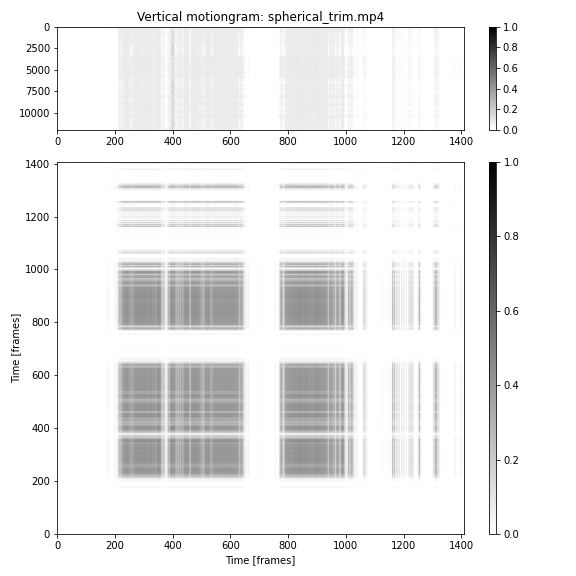

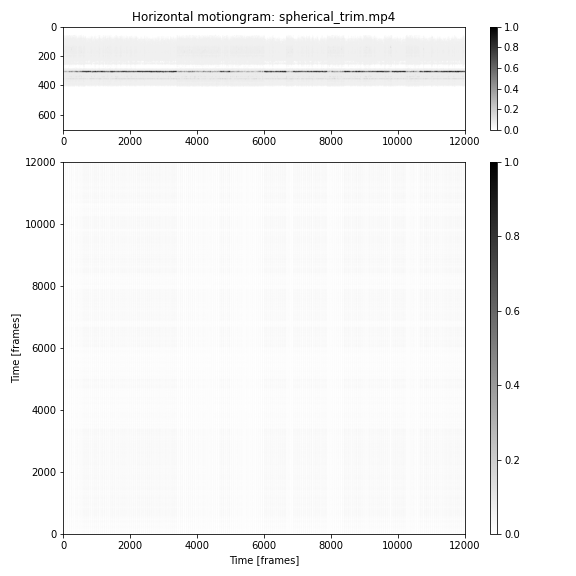

In [14]:
motionssm = video.ssm(features='motiongrams') # returns an MgList with the motion SSMs as MgImages
motionssm.show(mode="notebook") # view chromagram SSM

## Audio analysis - librosa

In [96]:
!ffmpeg -i spherical_trim.mp4 -c copy spherical_trim.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [97]:
y, sr = librosa.load('spherical_trim.wav', offset=100, duration=500)

ValueError: Input signal length=0 is too small to resample from 48000->22050

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(16,6))

librosa.display.waveshow(y, sr=sr)

ax.set(title='Audio waveform')
ax.legend()

fig.savefig("audio_waveform.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y, margin=3)

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(16,6))

#librosa.display.waveplot(y, sr=sr, ax=ax[0])

#ax[0].set(title='Envelope view, mono')
#ax[0].label_outer()

librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, label='Percussive')

ax.set(title='Audio waveforms of harmonic and percussive components')
ax.legend()

fig.savefig("audio_waveform_harmonic_percussive.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
D = librosa.stft(y)

In [ ]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log', x_axis='time')
plt.title('Spectrogram of audio recording')

plt.tight_layout()
plt.savefig("audio_spectrogram.pdf", bbox_inches='tight',facecolor='white', dpi=150)

In [ ]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

## Cleaning up

Convert all PDF files to jpg

In [47]:
!for i in *.pdf; do name=`echo $i | cut -d'.' -f1`; pdftoppm "$i" "$name" -jpeg -rx 150 -ry 150 -singlefile; done

In [26]:
!pdfcrop  video-plots.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `video-plots-crop.pdf'.


In [4]:
!pdftoppm video-plots-crop.pdf combined-plots-crop -jpeg -rx 150 -ry 150 -singlefile

I/O Error: Couldn't open file 'video-plots-crop.pdf': No such file or directory.
